# Data cleasing & preprocessing

This notebook performs following operations:
* Import data associated with a specific metric (label_score, string_score, free, rating)
* Clean/Subset data for each metrics respectively
* Merge/Concatenat data sets to a whole data set
* Export two data sets: 1. summary table (normalised & aggregated only for target responses) for plotting; 2. raw data (containing also non target responses) for stats test

In [409]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import reduce
from scipy.stats import pearsonr
from tqdm.notebook import tqdm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Import data sets

In [410]:
# Define the path to the 'free' subfolder
csv_folder_path = "processed_data"
csv_file_names = os.listdir(csv_folder_path)

wide_files = []
summary_files = []

# Loop through the filenames and read each "_wide" or "_summary" csv files
for file_name in csv_file_names:
    if "_wide" in file_name:
        # Construct the full file path
        wide_files.append(
            os.path.join(csv_folder_path, file_name)
        )
    elif "_summary" in file_name:
        # Construct the full file path
        summary_files.append(
            os.path.join(csv_folder_path, file_name)
        )

# Reading and storing dataframes in a list
dfs_wide = [pd.read_csv(file, on_bad_lines='skip', engine='python', sep=',') for file in wide_files]

print(dfs_wide[0].head(5))


          model_name  item_id       phenomenon        metric  \
0  google/flan-t5-xl        1        coherence  string_score   
1  google/flan-t5-xl        1          deceits  string_score   
2  google/flan-t5-xl        1           humour  string_score   
3  google/flan-t5-xl        1  indirect_speech  string_score   
4  google/flan-t5-xl        1            irony  string_score   

   sentence_cond_probs  mean_sentence_cond_probs  sentence_mi  \
0                    0                         0            1   
1                    0                         0            0   
2                    0                         0            1   
3                    0                         0            1   
4                    0                         1            1   

   sentence_surprisal  mean_sentence_surprisal  sentence_mi_surprisal  
0                   0                        0                      1  
1                   0                        0                      0  
2       

In [411]:
# Defining a function to merge two dataframes on 'model_name'
#def merge_dfs(left, right):
#    return pd.merge(left, right, on=['model_name','item_id','phenomenon', 'metric'], how='outer')

# Using reduce to apply the merge function to all dataframes in the list
#df_wide = reduce(merge_dfs, dfs_wide)

# Concatenate all data into one DataFrame
#df_summary = pd.concat([pd.read_csv(file, on_bad_lines='skip', engine='python', sep=',') for file in summary_files], ignore_index=True)

#df_summary, len(df_summary)
#print(df_wide.head())


## Import data of the metric string scores

In [412]:
# # Read the csv file into a pandas dataframe
df_string_scores = pd.read_csv(os.path.join(csv_folder_path, "string_scores_accuracy_summary.csv"))

# Subset the data by metric_formula == 'mean_sentence_surprisal', which is the best Config for the 'string_scores' metric
df_string_scores = df_string_scores[df_string_scores['metric_formula'] == 'mean_sentence_surprisal'].reset_index(drop=True)

# Drop the 'metric_formula' column
df_string_scores = df_string_scores.drop(columns=['metric_formula'])

print(df_string_scores)

                  model_name       phenomenon        metric  \
0          google/flan-t5-xl        coherence  string_score   
1          google/flan-t5-xl          deceits  string_score   
2          google/flan-t5-xl           humour  string_score   
3          google/flan-t5-xl  indirect_speech  string_score   
4          google/flan-t5-xl            irony  string_score   
5          google/flan-t5-xl           maxims  string_score   
6          google/flan-t5-xl         metaphor  string_score   
7     gpt-3.5-turbo-instruct        coherence  string_score   
8     gpt-3.5-turbo-instruct          deceits  string_score   
9     gpt-3.5-turbo-instruct           humour  string_score   
10    gpt-3.5-turbo-instruct  indirect_speech  string_score   
11    gpt-3.5-turbo-instruct            irony  string_score   
12    gpt-3.5-turbo-instruct           maxims  string_score   
13    gpt-3.5-turbo-instruct         metaphor  string_score   
14  meta-llama/Llama-2-7b-hf        coherence  string_s

# Import data of the metric label score

In [413]:
# Read the csv file into a pandas dataframe
df_label_scores = pd.read_csv(os.path.join(csv_folder_path, "label_scores_accuracy_bestConfigs_summary.csv"))

# Drop the metric_formula column
df_label_scores = df_label_scores.drop(columns=['metric_formula'])
print(df_label_scores)

                  model_name       phenomenon       metric  dependent_variable
0          google/flan-t5-xl        coherence  label_score            0.750000
1          google/flan-t5-xl          deceits  label_score            0.730000
2          google/flan-t5-xl           humour  label_score            0.296000
3          google/flan-t5-xl  indirect_speech  label_score            0.830000
4          google/flan-t5-xl            irony  label_score            0.544000
5          google/flan-t5-xl           maxims  label_score            0.452632
6          google/flan-t5-xl         metaphor  label_score            0.710000
7     gpt-3.5-turbo-instruct        coherence  label_score            0.580000
8     gpt-3.5-turbo-instruct          deceits  label_score            0.610000
9     gpt-3.5-turbo-instruct           humour  label_score            0.392000
10    gpt-3.5-turbo-instruct  indirect_speech  label_score            0.650000
11    gpt-3.5-turbo-instruct            irony  label

## Import data from the metric free

In [414]:
# Read the csv file into a pandas dataframe
df_free = pd.read_csv(os.path.join(csv_folder_path, "free_accuracy_summary.csv"))

# Repair zero values in the 'accuracy' column
# Creating a DataFrame for the new rows
new_rows = pd.DataFrame({
    'phenomenon': ['indirect_speech', 'humour'],
    'model_name': ['meta-llama/Llama-2-7b-hf', 'meta-llama/Llama-2-7b-hf'],
    'metric': ['free', 'free'],
    'dependent_variable': [0, 0]
})

# Concatenating the new rows to the existing DataFrame
df_free = pd.concat([df_free, new_rows], ignore_index=True)

# Displaying the updated DataFrame
print(df_free)

         phenomenon                model_name metric  dependent_variable
0         coherence         google/flan-t5-xl   free            0.800000
1         coherence    gpt-3.5-turbo-instruct   free            0.780000
2         coherence  meta-llama/Llama-2-7b-hf   free            0.287500
3         coherence          text-davinci-002   free            0.605000
4           deceits         google/flan-t5-xl   free            0.400000
5           deceits    gpt-3.5-turbo-instruct   free            0.800000
6           deceits  meta-llama/Llama-2-7b-hf   free            0.083333
7           deceits          text-davinci-002   free            0.660000
8            humour         google/flan-t5-xl   free            0.040000
9            humour    gpt-3.5-turbo-instruct   free            0.424000
10           humour          text-davinci-002   free            0.320000
11  indirect_speech         google/flan-t5-xl   free            0.550000
12  indirect_speech    gpt-3.5-turbo-instruct   fre

## Import data from the metric rating

In [415]:
# Read the csv file into a pandas dataframe
df_rating = pd.read_csv(os.path.join(csv_folder_path, "rating_accuracy_summary.csv"))

# Repair zero values in the 'accuracy' column
# Creating a DataFrame for the new rows
new_rows = pd.DataFrame({
    'phenomenon': ['indirect_speech', 'deceits'],
    'model_name': ['google/flan-t5-xl', 'meta-llama/Llama-2-7b-hf'],
    'metric': ['rating', 'rating'],
    'dependent_variable': [0, 0]
})

# Concatenating the new rows to the existing DataFrame
df_rating = pd.concat([df_rating, new_rows], ignore_index=True)

# Displaying the updated DataFrame
print(df_rating)

                  model_name       phenomenon  dependent_variable  metric
0          google/flan-t5-xl        coherence            0.475000  rating
1          google/flan-t5-xl          deceits            0.050000  rating
2          google/flan-t5-xl           humour            0.240000  rating
3          google/flan-t5-xl            irony            0.480000  rating
4          google/flan-t5-xl           maxims            0.105263  rating
5          google/flan-t5-xl         metaphor            0.250000  rating
6     gpt-3.5-turbo-instruct        coherence            0.375000  rating
7     gpt-3.5-turbo-instruct          deceits            0.600000  rating
8     gpt-3.5-turbo-instruct           humour            0.400000  rating
9     gpt-3.5-turbo-instruct  indirect_speech            0.700000  rating
10    gpt-3.5-turbo-instruct            irony            0.440000  rating
11    gpt-3.5-turbo-instruct           maxims            0.421053  rating
12    gpt-3.5-turbo-instruct         m

## Import human data

In [416]:
# Define the path to the 'free' subfolder
human_folder_path = "../human_data"

# Recursively list all csv files in the 'free' folder
csv_files = []
for root, dirs, files in os.walk(human_folder_path):
    for file in files:
        if file.endswith(".csv"):
            csv_files.append(os.path.join(root, file))

# Concatenate all annotated csv files into a single dataframe
df_human = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

# Map the name of phenomena from human data to model data
PHENOMENA_LLM_LINK = {
    "HV": "humour", 
    "IV": "irony",
    "ISV": "indirect_speech",
    "DV": "deceits",
    "CIV": "coherence",
    "MV": "maxims",
    "MPV": "metaphor"
}

# Remap the "Task" column
df_human['Task'] = df_human['Task'].map(PHENOMENA_LLM_LINK)

# Display the unique values
print(df_human['Task'].unique())
      
# Return the first few rows of the concatenated dataframe and the number of non-annotated files
df_human.head(), len(df_human)


['deceits' 'indirect_speech' 'irony' 'humour' 'maxims' 'metaphor'
 'coherence']


(   Unnamed: 0  pKey  itemNum  Correct     Task OptionChosen
 0           1   100        9        1  deceits      Answer3
 1           2   100       16        1  deceits      Answer3
 2           3   100       14        1  deceits      Answer3
 3           4   100       17        0  deceits      Answer2
 4           5   100       13        1  deceits      Answer3,
 63580)

In [417]:
# Normalize df_human
# Group by 'phenomenon', 'model_name', and 'response_option', then compute the counts
aggregated_counts_human = df_human.groupby(['Task', 'Correct']).size().reset_index(name='count')

# Compute the total count for each combination of 'Task' and 'itemNum'
total_counts_human = df_human.groupby(['Task']).size().reset_index(name='total_count')

# Merge the dataframes on 'phenomenon' and 'model_name'
normalized_counts_human = pd.merge(aggregated_counts_human, total_counts_human, on=['Task'])

# Compute the normalized count
normalized_counts_human['normalized_count'] = normalized_counts_human['count'] / normalized_counts_human['total_count']

# Pivot the table for better visualization
normalized_counts_human_pivot = normalized_counts_human.pivot_table(index=['Task'], columns='Correct', values='normalized_count').fillna(0)

# Reset index for the pivot table for plotting
normalized_counts_pivot_reset = normalized_counts_human_pivot.reset_index()

# Melt the DataFrame to have 'response_option' and 'normalized_count' as separate columns
melted_data = normalized_counts_pivot_reset.melt(id_vars=['Task'], 
                                                 value_vars=normalized_counts_human_pivot.columns, 
                                                 var_name='Correct', 
                                                 value_name='normalized_count')

# Filter out rows where normalized_count is zero to only plot non-zero responses
non_zero_melted_human_data = melted_data[(melted_data['normalized_count'] > 0) & (melted_data['Correct'] == True)]



# Rename the columns of human data
human_data_cleaned = non_zero_melted_human_data.copy()

human_data_cleaned.rename(columns={
    "Task": "phenomenon",
    "normalized_count": "dependent_variable"
}, inplace=True)
# Add two new columns with specified values
human_data_cleaned.loc[:,'model_name'] = 'human'
human_data_cleaned.loc[:,'metric'] = 'forced_choice'

# Drop column "Correct"
human_data_cleaned.drop(columns=['Correct'], inplace=True)
human_data_cleaned.reset_index(drop=True, inplace=True)

print(human_data_cleaned)

        phenomenon  dependent_variable model_name         metric
0        coherence            0.856684      human  forced_choice
1          deceits            0.841979      human  forced_choice
2           humour            0.846845      human  forced_choice
3  indirect_speech            0.885963      human  forced_choice
4            irony            0.919465      human  forced_choice
5           maxims            0.795856      human  forced_choice
6         metaphor            0.896791      human  forced_choice


In [418]:
# Define the list of metric values
model_names = ["google/flan-t5-xl", "gpt-3.5-turbo-instruct", "meta-llama/Llama-2-7b-hf", "text-davinci-002"]

# Duplicate df_human for each metric value and update the metric column
df_humans = [human_data_cleaned.copy().assign(model_name=model_name) for model_name in model_names]


# Concatenate all the dataframes together
df_human = pd.concat(df_humans, ignore_index=True)

# Rename metric column
df_human['metric'] = 'human'


df_human

,phenomenon,dependent_variable,model_name,metric
0,coherence,0.856684,google/flan-t5-xl,human
1,deceits,0.841979,google/flan-t5-xl,human
2,humour,0.846845,google/flan-t5-xl,human
3,indirect_speech,0.885963,google/flan-t5-xl,human
4,irony,0.919465,google/flan-t5-xl,human
5,maxims,0.795856,google/flan-t5-xl,human
6,metaphor,0.896791,google/flan-t5-xl,human
7,coherence,0.856684,gpt-3.5-turbo-instruct,human
8,deceits,0.841979,gpt-3.5-turbo-instruct,human
9,humour,0.846845,gpt-3.5-turbo-instruct,human


## Concat all data sets together

In [419]:
### Clean up the data set with more readable labels and styles ###

PHENOMENA_PRETTY = {
    "humour": "Humor", 
    "irony": "Irony",
    "indirect_speech": "IndirectSpeech",
    "deceits": "Deceits",
    "coherence": "Coherence",
    "maxims": "Maxims",
    "metaphor": "Metaphor"
}

METRIC_PRETTY = {
    "label_score": "Label score", 
    "string_score": "String score",
    "human": "Human",
    "free": "Free production",
    "rating": "Rating"
}

CHANCE = {
    "Humor": 1/5,
    "Irony": 1/4,
    "IndirectSpeech": 1/4,
    "Deceits": 1/4,
    "Coherence": 1/2,
    "Maxims": 1/4,
    "Metaphor": 1/5
}

MODELS = {
    "google/flan-t5-xl": "Flan-T5 (XL)",
    "meta-llama/Llama-2-7b-hf": "Llama-2 (7B)",
    "gpt-3.5-turbo-instruct": "InstructGPT-3.5",
    "text-davinci-002": "text-davinci-002",
    "human": "Human"
}

MODEL_ORDER = [ 
    "Llama-2 (7B)", 
    "Flan-T5 (XL)", 
    "InstructGPT-3.5", 
    "text-davinci-002", 
    "Human"
] # sorted(MODELS.values()) 

METRIC_ORDER = [ 
    "Human",
    "Free production", 
    "Rating", 
    "String score",
    "Label score"
] 

ARTIFICIAL_MODELS = [m for m in MODEL_ORDER if m != "Human"]
SEEDS = range(5)

# Styling for visualizations
sns.set(style="white", font="Arial", font_scale=1.5)
paired = sns.color_palette("Paired")
PAL_MODEL = {
    "Human": paired[11], #"lightgrey",
    "InstructGPT-3.5": paired[0],
    "text-davinci-002": paired[1],
    "Flan-T5 (XL)": paired[7],
    "Llama-2 (7B)": paired[2],
}
PAL_METRIC = {
    "Human": paired[11], #"lightgrey",
    "String score": paired[0],
    "Label score": paired[1],
    "Free production": paired[7],
    "Rating": paired[2],
}

ERR_STYLE = dict(errwidth=1, capsize=0.03)
CHANCE_STYLE = dict(color="k", ls="--", alpha=0.7, lw=2)

def render(outpath):
    plt.savefig(f"./plots/{outpath}", bbox_inches="tight", dpi=300)
    print(f"Rendered figure to {outpath}")



In [420]:
# Concat all five dataframes
df_all = pd.concat([df_label_scores, df_free, df_rating, df_human, df_string_scores], ignore_index=True)
df_all = df_all.reset_index(drop=True, inplace=False)

# Remap metric for prettier labels
# Display before
print(df_all['metric'].unique())

# Remap the "metric" column
df_all['metric'] = df_all['metric'].map(METRIC_PRETTY)

# Display after
print(df_all['metric'].unique())




['label_score' 'free' 'rating' 'human' 'string_score']
['Label score' 'Free production' 'Rating' 'Human' 'String score']


In [421]:
# Display before
print('Before remapping the "phenomenon" column')
print(df_all['phenomenon'].unique())

# Remap the "phenomenon" column
df_all['phenomenon'] = df_all['phenomenon'].map(PHENOMENA_PRETTY)

print('After remapping the "phenomenon" column')
print(df_all['phenomenon'].unique())

# Models and "pretty" names
# Display before
print('Before remapping the "model_name" column')
print(df_all['model_name'].unique())

# Remap the "model_name" column
df_all['model_name'] = df_all['model_name'].map(MODELS)

# Display after
print('After remapping the "model_name" column')
print(df_all['model_name'].unique())

# Make a copy of the dataframe for plotting
df_summary_plot = df_all.copy()

Before remapping the "phenomenon" column
['coherence' 'deceits' 'humour' 'indirect_speech' 'irony' 'maxims'
 'metaphor']
After remapping the "phenomenon" column
['Coherence' 'Deceits' 'Humor' 'IndirectSpeech' 'Irony' 'Maxims'
 'Metaphor']
Before remapping the "model_name" column
['google/flan-t5-xl' 'gpt-3.5-turbo-instruct' 'meta-llama/Llama-2-7b-hf'
 'text-davinci-002']
After remapping the "model_name" column
['Flan-T5 (XL)' 'InstructGPT-3.5' 'Llama-2 (7B)' 'text-davinci-002']


## Plot accuracy against phenomenon, facet by models, fill by metrics

In [422]:
df_summary_plot

,model_name,phenomenon,metric,dependent_variable
0,Flan-T5 (XL),Coherence,Label score,0.750000
1,Flan-T5 (XL),Deceits,Label score,0.730000
2,Flan-T5 (XL),Humor,Label score,0.296000
3,Flan-T5 (XL),IndirectSpeech,Label score,0.830000
4,Flan-T5 (XL),Irony,Label score,0.544000
...,...,...,...,...
135,text-davinci-002,Humor,String score,0.760000
136,text-davinci-002,IndirectSpeech,String score,0.650000
137,text-davinci-002,Irony,String score,0.440000
138,text-davinci-002,Maxims,String score,0.526316


In [423]:
# import matplotlib.lines as mlines

# def plot_accuracy(df):
#     PHEN_ORDER = sorted(df.phenomenon.unique())
#     ax = sns.catplot(
#         data=df, 
#         x="phenomenon", 
#         y="dependent_variable", 
#         hue="metric", 
#         hue_order=MODEL_ORDER, 
#         palette=PAL, 
#         col="model_name",  # Faceting by model_name here
#         kind="bar",
#         height=4,
#         aspect=1.2,
#         order=PHEN_ORDER, 
#         #**ERR_STYLE  # Assuming ERR_STYLE is a dictionary with valid arguments
#     )
#     ax.set_xlabel("")
#     ax.set_ylabel("Proportion correct")
#     handles, labels = ax.get_legend_handles_labels()
#     handles.append(mlines.Line2D([], [], **CHANCE_STYLE))
#     labels.append("Random")
#     ax.legend(handles, labels, title="", loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.gcf().set_size_inches(18,4)
    
#     n_phen = len(PHEN_ORDER)
#     for i, phen in enumerate(PHEN_ORDER):
#         # Draw different random baseline for each task
#         ax.axhline(y=CHANCE[phen], xmin=(1/n_phen)*i + 0.01, xmax=(1/n_phen)*(i+1) - 0.01, **CHANCE_STYLE)
    
# #plot_accuracy(df_summary_plot)
# #render("all_accuracy_summary.pdf")

/var/folders/jc/6ctllcx143xbrgx01x69skg80000gn/T/ipykernel_76078/3072901506.py:9: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  g = sns.catplot(


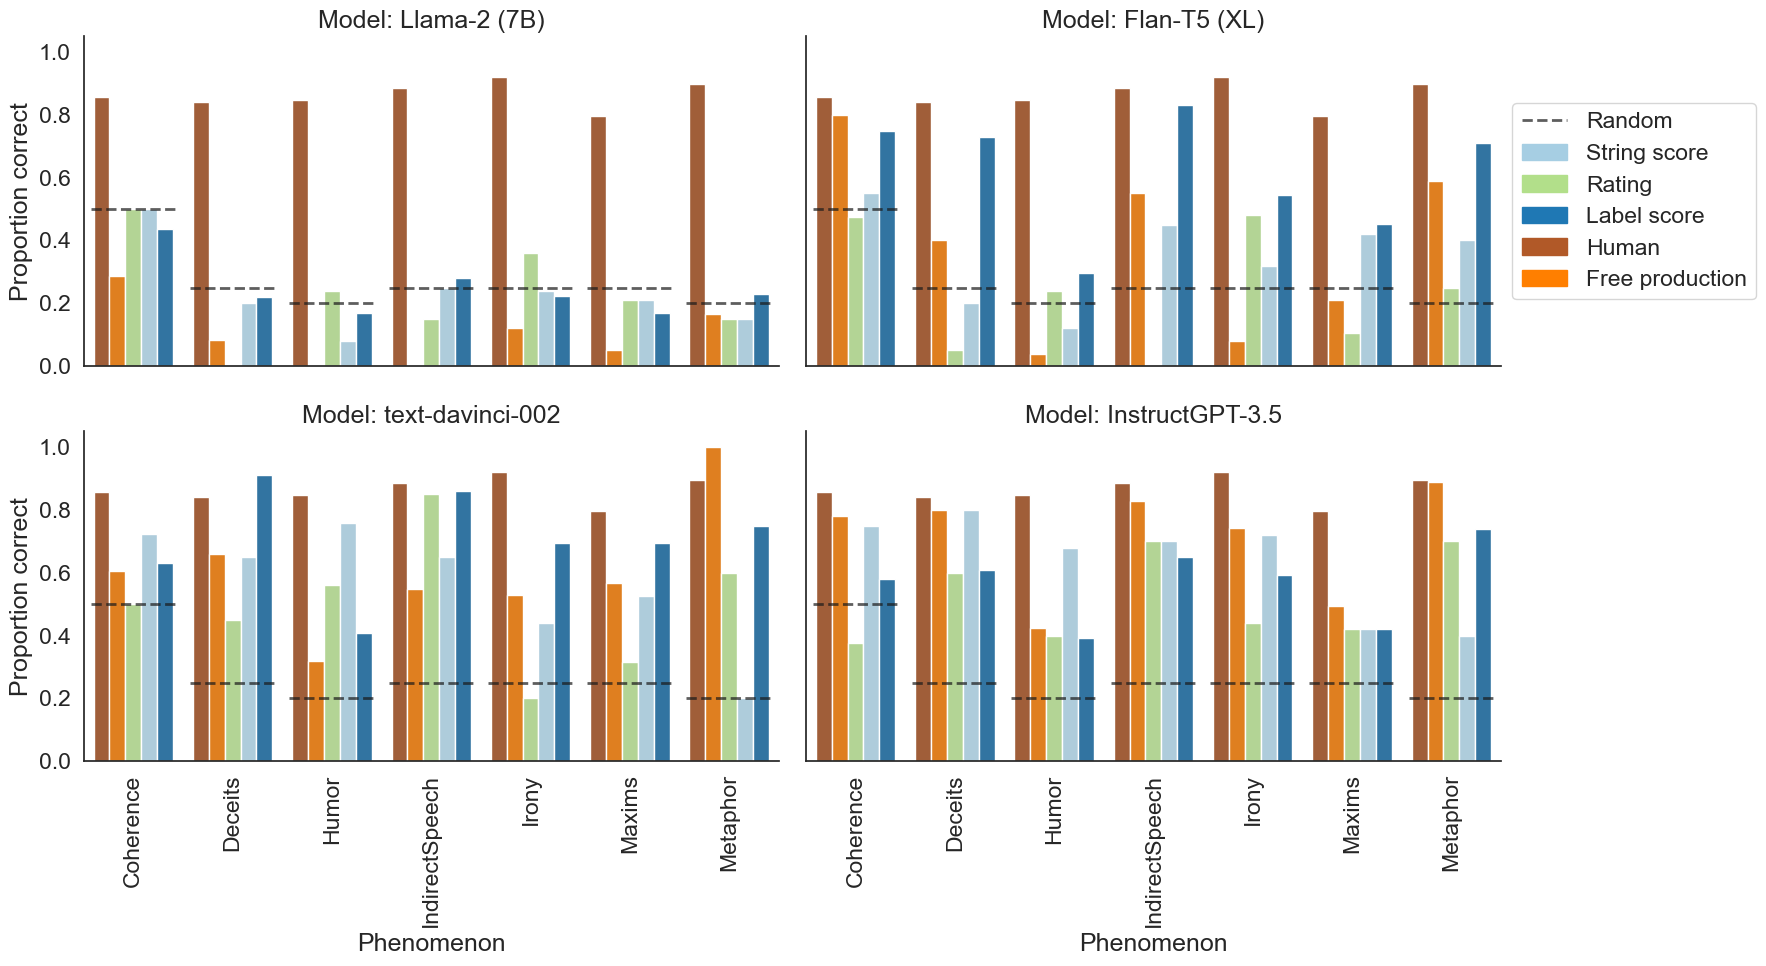

In [424]:
import matplotlib.patches as mpatches

PHEN_ORDER = sorted(df_summary_plot.phenomenon.unique())

# Sorting the DataFrame based on the absolute values of 'dependent_variable'
df_summary_plot.sort_values(by=['metric', 'dependent_variable'], ascending=[False, True], inplace=True)
                            

g = sns.catplot(
    data=df_summary_plot, 
    x="phenomenon", 
    y="dependent_variable", 
    hue="metric", 
    hue_order=METRIC_ORDER, 
    palette=PAL_METRIC, 
    col="model_name",  # Faceting by model_name here
    col_wrap=2,  # Optional: number of columns when wrapping facets
    kind="bar",
    height=4,
    aspect=0.8,
    legend=False,
    order=PHEN_ORDER, 
    **ERR_STYLE  # Assuming ERR_STYLE is a dictionary with valid arguments
)

g.fig.set_size_inches(18, 10)
g.set_axis_labels("Phenomenon", "Proportion correct")
g.set_titles("Model: {col_name}")

# Rotate x-axis labels for each subplot
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

# Iterating over each Axes object (facet) in your catplot
for ax in g.axes.flat:
    n_phen = len(PHEN_ORDER)
    
    for i, phen in enumerate(PHEN_ORDER):
        # Draw different random baseline for each task
        ax.axhline(y=CHANCE[phen], xmin=(1/n_phen)*i + 0.01, xmax=(1/n_phen)*(i+1) - 0.01, **CHANCE_STYLE)

# Assuming adding_labels and adding_handles are lists or arrays
# and PAL_METRIC is a dictionary or something that maps metrics to colors/styles
adding_labels = df_summary_plot['metric'].unique()  # Ensure this is a list or array
adding_handles = [mpatches.Patch(color=PAL_METRIC[label], label=label) for label in adding_labels]


# Handling the legend
ax = g.facet_axis(2, 1)
handles, labels = ax.get_legend_handles_labels()
handles.append(mlines.Line2D([], [], **CHANCE_STYLE))
labels.append("Random")

# Appending adding_labels and adding_handles to labels and handles
labels.extend(adding_labels)
handles.extend(adding_handles)

# Set up legend
ax.legend(handles, labels, title="", loc='center left', bbox_to_anchor=(1, 0.5))
#plt.gcf().set_size_inches(18,4)

# Move the legend to the right outside of the plot area
#g._legend.set_bbox_to_anchor((1.25, 0.6))
#g._legend.set_frame_on(True)
#g._legend.set_title("Metrics")

plt.tight_layout()
plt.show()


In [ ]:
# Define the path to save the plot as PDF
save_path = "plots/accuracy_all_summary.pdf"

# Ensure the directory exists
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the plot to the specified path
g.savefig(save_path, bbox_inches='tight')

save_path


'plots/accuracy_all_summary.pdf'

# Export CSV files for further analysis

In total of two CSVs need to be exported:
* all_summary: contains normalised proportion of correctness given the best config from the associated metric, aggregated by model, phenomenon, and metric
* all_raw: contains raw data of binary response given items, aggregated by model, phenomenon, seed (if availible), and metric

## Export summary data

In [ ]:
# Rename the column 'dependent_variable' to 'accuracy'
df_summary_plot.rename(columns={'dependent_variable' : 'accuracy'}, inplace=True)

# Display data set before exporting
print(df_summary_plot)

# Save csv file
summary_out_path = "processed_all_data/all_accuracy_summary.csv"

# Ensure the directory exists
os.makedirs(os.path.dirname(summary_out_path), exist_ok=True)

# Save the csv to the specified path
df_summary_plot.to_csv(summary_out_path, index=False)

           model_name      phenomenon           metric  accuracy
136  text-davinci-002  IndirectSpeech     String score      0.05
118      Flan-T5 (XL)        Metaphor     String score      0.10
125   InstructGPT-3.5        Metaphor     String score      0.10
116      Flan-T5 (XL)           Irony     String score      0.12
121   InstructGPT-3.5           Humor     String score      0.12
..                ...             ...              ...       ...
28       Flan-T5 (XL)       Coherence  Free production      0.80
33    InstructGPT-3.5         Deceits  Free production      0.80
40    InstructGPT-3.5  IndirectSpeech  Free production      0.83
51    InstructGPT-3.5        Metaphor  Free production      0.89
53   text-davinci-002        Metaphor  Free production      1.00

[140 rows x 4 columns]


## Export raw data with best Config respectively (if availible)

In [ ]:
# Define raw_path
raw_label_score_path = "processed_data/label_scores_argmax_wide_label.typ_seed.csv"

raw_string_score_path = "processed_data/string_scores_argmax_wide.csv"

raw_free_path = "processed_data/free_accuracy_wide.csv"

raw_rating_path = "processed_data/rating_accuracy_wide.csv"

In [ ]:
# Clean up df_label_score_raw
df_label_score_raw_bestConfig = pd.read_csv(raw_label_score_path)
df_label_score_raw_bestConfig = df_label_score_raw_bestConfig[df_label_score_raw_bestConfig['label_type'] == 'label_alpha']
df_label_score_raw_bestConfig.drop(columns=['sentence_cond_probs','mean_sentence_cond_probs','sentence_surprisal','mean_sentence_surprisal','sentence_mi_surprisal', 'label_type'], inplace=True)
df_label_score_raw_bestConfig.rename(columns={'sentence_mi': 'dependent_variable'}, inplace=True)
df_label_score_raw_bestConfig

,model_name,item_id,seed,phenomenon,metric,dependent_variable
0,google/flan-t5-xl,1,0,coherence,label_score,1.0
2,google/flan-t5-xl,1,0,deceits,label_score,0.0
4,google/flan-t5-xl,1,0,humour,label_score,0.0
6,google/flan-t5-xl,1,0,indirect_speech,label_score,1.0
8,google/flan-t5-xl,1,0,irony,label_score,0.0
...,...,...,...,...,...,...
6750,text-davinci-002,36,4,coherence,label_score,1.0
6752,text-davinci-002,37,4,coherence,label_score,1.0
6754,text-davinci-002,38,4,coherence,label_score,1.0
6756,text-davinci-002,39,4,coherence,label_score,0.0


In [ ]:
# Clean up df_string_score_raw
df_string_score_raw_bestConfig = pd.read_csv(raw_string_score_path)
df_string_score_raw_bestConfig.drop(columns=['sentence_cond_probs','mean_sentence_cond_probs','sentence_surprisal','sentence_mi','sentence_mi_surprisal'], inplace=True)
df_string_score_raw_bestConfig.rename(columns={'mean_sentence_surprisal': 'dependent_variable'}, inplace=True)
df_string_score_raw_bestConfig['seed'] = 0
df_string_score_raw_bestConfig

,model_name,item_id,phenomenon,metric,dependent_variable,seed
0,google/flan-t5-xl,1,coherence,string_score,1,0
1,google/flan-t5-xl,1,deceits,string_score,1,0
2,google/flan-t5-xl,1,humour,string_score,0,0
3,google/flan-t5-xl,1,indirect_speech,string_score,0,0
4,google/flan-t5-xl,1,irony,string_score,0,0
...,...,...,...,...,...,...
671,text-davinci-002,36,coherence,string_score,0,0
672,text-davinci-002,37,coherence,string_score,0,0
673,text-davinci-002,38,coherence,string_score,1,0
674,text-davinci-002,39,coherence,string_score,1,0


In [ ]:
# Clean up df_string_score_raw
df_free_raw_bestConfig = pd.read_csv(raw_free_path)
df_free_raw_bestConfig.rename(columns={'response_option': 'dependent_variable'}, inplace=True)
df_free_raw_bestConfig 
#df_string_score_raw.drop(columns=['sentence_cond_probs','mean_sentence_cond_probs','sentence_surprisal','sentence_mi','sentence_mi_surprisal'], inplace=True)
#df_string_score_raw.rename(columns={'mean_sentence_surprisal': 'dependent_variable'}, inplace=True)
#df_string_score_raw

,dependent_variable,phenomenon,model_name,item_id,seed,metric
0,0,humour,meta-llama/Llama-2-7b-hf,1.0,3.0,free
1,0,humour,meta-llama/Llama-2-7b-hf,2.0,3.0,free
2,0,humour,meta-llama/Llama-2-7b-hf,3.0,3.0,free
3,0,humour,meta-llama/Llama-2-7b-hf,4.0,3.0,free
4,0,humour,meta-llama/Llama-2-7b-hf,5.0,3.0,free
...,...,...,...,...,...,...
3077,0,irony,google/flan-t5-xl,21.0,1.0,free
3078,0,irony,google/flan-t5-xl,22.0,1.0,free
3079,0,irony,google/flan-t5-xl,23.0,1.0,free
3080,0,irony,google/flan-t5-xl,24.0,1.0,free


In [ ]:
# Read the csv file into a pandas dataframe
df_rating_raw_bestConfig = pd.read_csv(raw_rating_path)

# Rename the column 'chosen_option' to 'dependent_variable'
df_rating_raw_bestConfig.rename(columns={'chosen_option': 'dependent_variable'}, inplace=True)


# Assuming df_rating is your DataFrame
df_rating_raw_bestConfig = df_rating_raw_bestConfig.drop_duplicates(subset=['item_id', 'phenomenon', 'model_name'])

df_rating_raw_bestConfig

,dependent_variable,phenomenon,model_name,item_id,seed,metric
0,0,deceits,meta-llama/Llama-2-7b-hf,1,0,rating
4,0,deceits,meta-llama/Llama-2-7b-hf,2,0,rating
8,0,deceits,meta-llama/Llama-2-7b-hf,3,0,rating
12,0,deceits,meta-llama/Llama-2-7b-hf,4,0,rating
16,0,deceits,meta-llama/Llama-2-7b-hf,5,0,rating
...,...,...,...,...,...,...
2539,0,metaphor,google/flan-t5-xl,16,0,rating
2544,0,metaphor,google/flan-t5-xl,17,0,rating
2549,0,metaphor,google/flan-t5-xl,18,0,rating
2554,0,metaphor,google/flan-t5-xl,19,0,rating


In [ ]:
# Concat all five dataframes
df_all_raw_bestConfig = pd.concat([df_label_score_raw_bestConfig, df_string_score_raw_bestConfig, df_free_raw_bestConfig, df_rating_raw_bestConfig], ignore_index=True)

df_all_raw_bestConfig

,model_name,item_id,seed,phenomenon,metric,dependent_variable
0,google/flan-t5-xl,1.0,0.0,coherence,label_score,1.0
1,google/flan-t5-xl,1.0,0.0,deceits,label_score,0.0
2,google/flan-t5-xl,1.0,0.0,humour,label_score,0.0
3,google/flan-t5-xl,1.0,0.0,indirect_speech,label_score,1.0
4,google/flan-t5-xl,1.0,0.0,irony,label_score,0.0
...,...,...,...,...,...,...
7809,google/flan-t5-xl,16.0,0.0,metaphor,rating,0.0
7810,google/flan-t5-xl,17.0,0.0,metaphor,rating,0.0
7811,google/flan-t5-xl,18.0,0.0,metaphor,rating,0.0
7812,google/flan-t5-xl,19.0,0.0,metaphor,rating,0.0


In [ ]:
# Save csv file
raw_out_path = "processed_all_data/all_accuracy_raw_bestConfig.csv"

# Ensure the directory exists
os.makedirs(os.path.dirname(raw_out_path), exist_ok=True)

# Save the csv to the specified path
df_all_raw_bestConfig.to_csv(raw_out_path, index=False)

## Export raw data with all infos and all configs

In [ ]:
# Clean up df_label_score_raw
df_label_score_raw = pd.read_csv(raw_label_score_path)
df_label_score_raw = df_label_score_raw[df_label_score_raw['label_type'] == 'label_alpha']
#df_label_score_raw.drop(columns=['sentence_cond_probs','mean_sentence_cond_probs','sentence_surprisal','mean_sentence_surprisal','sentence_mi_surprisal', 'label_type'], inplace=True)
#df_label_score_raw.rename(columns={'sentence_mi': 'dependent_variable'}, inplace=True)
df_label_score_raw

,model_name,item_id,seed,phenomenon,metric,label_type,sentence_cond_probs,mean_sentence_cond_probs,sentence_mi,sentence_surprisal,mean_sentence_surprisal,sentence_mi_surprisal
0,google/flan-t5-xl,1,0,coherence,label_score,label_alpha,1.0,1.0,1.0,1.0,1.0,0.0
2,google/flan-t5-xl,1,0,deceits,label_score,label_alpha,1.0,1.0,0.0,1.0,1.0,0.0
4,google/flan-t5-xl,1,0,humour,label_score,label_alpha,0.0,0.0,0.0,0.0,0.0,0.0
6,google/flan-t5-xl,1,0,indirect_speech,label_score,label_alpha,1.0,1.0,1.0,1.0,1.0,0.0
8,google/flan-t5-xl,1,0,irony,label_score,label_alpha,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6750,text-davinci-002,36,4,coherence,label_score,label_alpha,1.0,1.0,1.0,1.0,1.0,0.0
6752,text-davinci-002,37,4,coherence,label_score,label_alpha,1.0,1.0,1.0,1.0,1.0,0.0
6754,text-davinci-002,38,4,coherence,label_score,label_alpha,1.0,1.0,1.0,1.0,1.0,0.0
6756,text-davinci-002,39,4,coherence,label_score,label_alpha,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Clean up df_string_score_raw
df_string_score_raw = pd.read_csv(raw_string_score_path)
#df_string_score_raw.drop(columns=['sentence_cond_probs','mean_sentence_cond_probs','sentence_surprisal','sentence_mi','sentence_mi_surprisal'], inplace=True)
#df_string_score_raw.rename(columns={'mean_sentence_surprisal': 'dependent_variable'}, inplace=True)
df_string_score_raw['seed'] = 0
df_string_score_raw

,model_name,item_id,phenomenon,metric,sentence_cond_probs,mean_sentence_cond_probs,sentence_mi,sentence_surprisal,mean_sentence_surprisal,sentence_mi_surprisal,seed
0,google/flan-t5-xl,1,coherence,string_score,1,1,1,1,1,0,0
1,google/flan-t5-xl,1,deceits,string_score,1,1,1,1,1,1,0
2,google/flan-t5-xl,1,humour,string_score,1,0,0,1,0,0,0
3,google/flan-t5-xl,1,indirect_speech,string_score,0,0,0,0,0,1,0
4,google/flan-t5-xl,1,irony,string_score,1,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
671,text-davinci-002,36,coherence,string_score,0,1,0,0,0,1,0
672,text-davinci-002,37,coherence,string_score,1,0,0,1,0,1,0
673,text-davinci-002,38,coherence,string_score,0,1,1,0,1,0,0
674,text-davinci-002,39,coherence,string_score,1,0,1,1,1,0,0


In [ ]:
# Clean up df_string_score_raw
df_free_raw = pd.read_csv(raw_free_path)
df_free_raw.rename(columns={'response_option': 'response'}, inplace=True)
df_free_raw 
#df_string_score_raw.drop(columns=['sentence_cond_probs','mean_sentence_cond_probs','sentence_surprisal','sentence_mi','sentence_mi_surprisal'], inplace=True)
#df_string_score_raw.rename(columns={'mean_sentence_surprisal': 'dependent_variable'}, inplace=True)
#df_string_score_raw

,response,phenomenon,model_name,item_id,seed,metric
0,0,humour,meta-llama/Llama-2-7b-hf,1.0,3.0,free
1,0,humour,meta-llama/Llama-2-7b-hf,2.0,3.0,free
2,0,humour,meta-llama/Llama-2-7b-hf,3.0,3.0,free
3,0,humour,meta-llama/Llama-2-7b-hf,4.0,3.0,free
4,0,humour,meta-llama/Llama-2-7b-hf,5.0,3.0,free
...,...,...,...,...,...,...
3077,0,irony,google/flan-t5-xl,21.0,1.0,free
3078,0,irony,google/flan-t5-xl,22.0,1.0,free
3079,0,irony,google/flan-t5-xl,23.0,1.0,free
3080,0,irony,google/flan-t5-xl,24.0,1.0,free


In [ ]:
# Import df_rating_raw
df_rating_raw = pd.read_csv(raw_rating_path)

# Rename the column 'chosen_option' to 'response'
df_rating_raw.rename(columns={'chosen_option': 'response'}, inplace=True)


# Assuming df_rating is your DataFrame
df_rating_raw = df_rating_raw.drop_duplicates(subset=['item_id', 'phenomenon', 'model_name']).reset_index(drop=True)

df_rating_raw

,response,phenomenon,model_name,item_id,seed,metric
0,0,deceits,meta-llama/Llama-2-7b-hf,1,0,rating
1,0,deceits,meta-llama/Llama-2-7b-hf,2,0,rating
2,0,deceits,meta-llama/Llama-2-7b-hf,3,0,rating
3,0,deceits,meta-llama/Llama-2-7b-hf,4,0,rating
4,0,deceits,meta-llama/Llama-2-7b-hf,5,0,rating
...,...,...,...,...,...,...
671,0,metaphor,google/flan-t5-xl,16,0,rating
672,0,metaphor,google/flan-t5-xl,17,0,rating
673,0,metaphor,google/flan-t5-xl,18,0,rating
674,0,metaphor,google/flan-t5-xl,19,0,rating


In [ ]:
# Concat all five dataframes
df_all_raw = pd.concat([df_label_score_raw, df_string_score_raw, df_free_raw, df_rating_raw], ignore_index=True)
df_all_raw

,model_name,item_id,seed,phenomenon,metric,label_type,sentence_cond_probs,mean_sentence_cond_probs,sentence_mi,sentence_surprisal,mean_sentence_surprisal,sentence_mi_surprisal,response
0,google/flan-t5-xl,1.0,0.0,coherence,label_score,label_alpha,1.0,1.0,1.0,1.0,1.0,0.0,NaN
1,google/flan-t5-xl,1.0,0.0,deceits,label_score,label_alpha,1.0,1.0,0.0,1.0,1.0,0.0,NaN
2,google/flan-t5-xl,1.0,0.0,humour,label_score,label_alpha,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,google/flan-t5-xl,1.0,0.0,indirect_speech,label_score,label_alpha,1.0,1.0,1.0,1.0,1.0,0.0,NaN
4,google/flan-t5-xl,1.0,0.0,irony,label_score,label_alpha,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7809,google/flan-t5-xl,16.0,0.0,metaphor,rating,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
7810,google/flan-t5-xl,17.0,0.0,metaphor,rating,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
7811,google/flan-t5-xl,18.0,0.0,metaphor,rating,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
7812,google/flan-t5-xl,19.0,0.0,metaphor,rating,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [ ]:
# Save csv file
raw_out_path = "processed_all_data/all_accuracy_raw.csv"

# Ensure the directory exists
os.makedirs(os.path.dirname(raw_out_path), exist_ok=True)

# Save the csv to the specified path
df_all_raw.to_csv(raw_out_path, index=False)